# Sprint1

# 題材
kaggle : Toxic Comment Classification Challenge
# 背景  

スマホアプリに表示される広告の不正クリックが問題となっている。  
広告主は、広告をクリックしてもらい、さらに、自分達が作成したアプリをダウンロードしてもらいたいのだが、  
クリックによって発生する広告料を狙って、クリックだけを行う者たちが存在する。  
そのため、広告主達は、アプリをダウンロードしてくれる人かどうか判別できる技術を望んでいる。


# 今回の目的

広告をクリックした者たちのIPアドレスや広告クリック時間、アプリをダウンロードしたかどうかなどの
情報を手掛かり  
にしてアプリをダウンロードしてくれる人かどうか見分けるモデルを作成する。

手順  
１、データの取得  
２、データの傾向および特徴を調査    
３、特徴量の加工    
４、モデルの訓練（データの作成および実施）  
５、モデルの検証（交差検証およびROCの作成）  
６、まとめ

## 1、データの取得（および各種インポート）  

     ・訓練データは処理速度を考慮して１０万件のtrain_sampleを選択する

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#train_df = pd.read_csv('tracking/train.csv')

test_df = pd.read_csv('tracking/test.csv')


In [1]:
#ランダムに行を指定するのための乱数
import random
random.randint(0, 180000000)

68

In [19]:
aa=random.sample(range(180000000), 2)
aa

[22195158, 168498709]

In [25]:
df1=pd.DataFrame()
print(df1)
for i in aa:
    print(i)
    train_df = pd.read_csv('tracking/train.csv',skiprows=i,nrows=1)
    print(train_df)
    df1=pd.concat([df1, train_df], ignore_index=False)
df1

Empty DataFrame
Columns: []
Index: []
22195158
   83306   2  1  13  435  2017-11-07 03:53:50  Unnamed: 6  0
0  21069  18  1  28  107  2017-11-07 03:53:50         NaN  0
168498709
   112302   7  1  19  101  2017-11-09 11:03:48  Unnamed: 6  0
0  119289  14  1  40  489  2017-11-09 11:03:48         NaN  0


,0,1,101,112302,13,19,2,2017-11-07 03:53:50,2017-11-09 11:03:48,435,7,83306,Unnamed: 6
0,0,1,NaN,NaN,28.0,NaN,18.0,2017-11-07 03:53:50,NaN,107.0,NaN,21069.0,NaN
0,0,1,489.0,119289.0,NaN,40.0,NaN,NaN,2017-11-09 11:03:48,NaN,14.0,NaN,NaN


In [14]:
train_df = pd.read_csv('tracking/train.csv',skiprows=2,nrows=2)

In [10]:
type(train_df)

pandas.core.frame.DataFrame

In [15]:
train_df

,17357,3,1,19,379,2017-11-06 14:33:34,Unnamed: 6,0
0,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
1,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0


## ２、データの傾向、特徴を調査

訓練データの中身の先頭付近を確認する

In [89]:
train_df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


訓練データの中身の末尾付近を確認する

In [90]:
train_df.tail()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0
99999,119349,14,1,15,401,2017-11-07 14:32:27,NaN,0


訓練データとテストデータの行数や列名、データ型等の情報を確認する

In [91]:
print(train_df.info())
print('_'*40)
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
dtypes: int64(6), object(2)
memory usage: 6.1+ MB
None
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18790469 entries, 0 to 18790468
Data columns (total 7 columns):
click_id      int64
ip            int64
app           int64
device        int64
os            int64
channel       int64
click_time    object
dtypes: int64(6), object(1)
memory usage: 1003.5+ MB
None


訓練データの各列の統計データを確認する（文字列データで構成された列は除く）

In [92]:
train_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91255.879670,12.04788,21.771250,22.818280,268.832460,0.002270
std,69835.553661,14.94150,259.667767,55.943136,129.724248,0.047591
min,9.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,40552.000000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,79827.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,118252.000000,15.00000,1.000000,19.000000,379.000000,0.000000
max,364757.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


訓練データにおいて文字列データで構成された列の情報を確認する

In [93]:
train_df.describe(include=['O'])

,click_time,attributed_time
count,100000,227
unique,80350,227
top,2017-11-08 12:01:02,2017-11-09 01:04:00
freq,7,1


各appごとのアトリビュート割合を確認する

In [94]:
train_df[['app', 'is_attributed']].groupby(['app'], as_index=False).mean()\
.sort_values(by='is_attributed',ascending=False)


,app,is_attributed
98,115,1.000000
99,116,1.000000
85,96,1.000000
112,145,1.000000
64,71,1.000000
138,261,1.000000
94,108,0.666667
33,34,0.666667
34,35,0.551020
65,72,0.375000


各deviceごとのアトリビュート割合を確認する

In [95]:
train_df[['device', 'is_attributed']].groupby(['device'], as_index=False).mean()\
.sort_values(by='is_attributed',ascending=False)


,device,is_attributed
61,351,1.000000
73,579,1.000000
17,36,1.000000
81,957,1.000000
39,116,1.000000
74,581,1.000000
34,102,1.000000
46,180,1.000000
48,188,1.000000
13,21,0.666667


各osごとのアトリビュート割合を確認する

In [96]:
train_df[['os', 'is_attributed']].groupby(['os'], as_index=False).mean()\
.sort_values(by='is_attributed',ascending=False)


,os,is_attributed
58,61,1.000000
29,29,0.196429
56,59,0.142857
24,24,0.134021
21,21,0.133333
0,0,0.130653
7,7,0.044248
37,38,0.032967
129,866,0.017391
42,43,0.010526


各channelごとのアトリビュート割合を求める

In [97]:
train_df[['channel', 'is_attributed']].groupby(['channel'], as_index=False).mean()\
.sort_values(by='is_attributed',ascending=False)


,channel,is_attributed
141,465,1.000000
19,114,1.000000
119,419,0.800000
2,5,0.714286
74,274,0.705882
78,282,0.294118
42,171,0.200000
53,213,0.173077
47,203,0.166667
92,341,0.166667


各click_timeごとのアトリビュート割合を求める

In [98]:
train_df[['click_time', 'is_attributed']].groupby(['click_time'], as_index=False).mean()\
.sort_values(by='is_attributed',ascending=False)


,click_time,is_attributed
2564,2017-11-06 21:00:30,1.0
22632,2017-11-07 13:19:35,1.0
39534,2017-11-08 06:19:39,1.0
25850,2017-11-07 15:45:36,1.0
58266,2017-11-09 00:16:38,1.0
10814,2017-11-07 04:30:20,1.0
35768,2017-11-08 03:38:31,1.0
79677,2017-11-09 15:27:07,1.0
18176,2017-11-07 10:05:58,1.0
48315,2017-11-08 12:41:31,1.0


各attributed_timeごとのアトリビュート割合を求める

In [99]:
train_df[['attributed_time', 'is_attributed']].groupby(['attributed_time'],\
                                                       as_index=False).mean().sort_values(by='is_attributed',\
                                                                                          ascending=False)

,attributed_time,is_attributed
0,2017-11-06 17:19:04,1
170,2017-11-09 02:12:43,1
144,2017-11-08 14:09:52,1
145,2017-11-08 14:17:26,1
146,2017-11-08 14:22:43,1
147,2017-11-08 14:25:07,1
148,2017-11-08 14:28:21,1
149,2017-11-08 14:30:55,1
150,2017-11-08 14:35:39,1
151,2017-11-08 14:40:50,1


## 3、特徴量の加工  

     ・そのままでは訓練に使えないclick_time列の値を加工（型変換、何時かを抽出、新変数割当）

訓練データのhour列のデータ型をobject から int8 に変更する

In [100]:
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('int8')

変更結果の確認

In [101]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
ip                 100000 non-null int64
app                100000 non-null int64
device             100000 non-null int64
os                 100000 non-null int64
channel            100000 non-null int64
click_time         100000 non-null object
attributed_time    227 non-null object
is_attributed      100000 non-null int64
hour               100000 non-null int8
dtypes: int64(6), int8(1), object(2)
memory usage: 6.2+ MB


訓練データのday列のデータ型をobjectからint8に変更する

In [102]:
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('int8') 

訓練データの click_time 列のデータを属する時間帯を表す数値に置き換える （２４時間を３時間ごとに区切り、０〜７の値を割り当てる）

In [103]:
train_df.loc[(train_df['hour'] >=0 ) & (train_df['hour']  < 3) , 'click_time'] = 0
train_df.loc[(train_df['hour'] >= 3) & (train_df['hour'] < 6), 'click_time'] = 1
train_df.loc[(train_df['hour'] >= 6) & (train_df['hour'] < 9), 'click_time'] = 2
train_df.loc[(train_df['hour'] >= 9) & (train_df['hour'] < 12), 'click_time'] = 3
train_df.loc[(train_df['hour'] >= 12) & (train_df['hour'] < 15), 'click_time'] = 4
train_df.loc[(train_df['hour'] >= 15) & (train_df['hour'] < 18), 'click_time'] = 5
train_df.loc[(train_df['hour'] >= 18) & (train_df['hour'] < 21), 'click_time'] = 6
train_df.loc[(train_df['hour'] >= 21) & (train_df['hour'] <= 23), 'click_time'] = 7
train_df.head() 

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,hour,day
0,87540,12,1,13,497,3,NaN,0,9,7
1,105560,25,1,17,259,4,NaN,0,13,7
2,101424,12,1,19,212,6,NaN,0,18,7
3,94584,13,1,13,477,1,NaN,0,4,7
4,68413,12,1,1,178,3,NaN,0,9,9


テストデータの click_time 列のデータ型を object から int8 へ変更する

In [104]:
test_df['click_time'] = pd.to_datetime(test_df.click_time).dt.hour.astype('int8')

テストデータの click_time 列のデータを属する時間帯を表す数値に置き換える
（２４時間を３時間ごとに区切り、０〜７の値を割り当てる）

In [105]:
test_df.loc[(test_df['click_time'] >=0 ) & (test_df['click_time']  < 3) , 'click_time'] = 0
test_df.loc[(test_df['click_time'] >= 3) & (test_df['click_time'] < 6), 'click_time'] = 1
test_df.loc[(test_df['click_time'] >= 6) & (test_df['click_time'] < 9), 'click_time'] = 2
test_df.loc[(test_df['click_time'] >= 9) & (test_df['click_time'] < 12), 'click_time'] = 3
test_df.loc[(test_df['click_time'] >= 12) & (test_df['click_time'] < 15), 'click_time'] = 4
test_df.loc[(test_df['click_time'] >= 15) & (test_df['click_time'] < 18), 'click_time'] = 5
test_df.loc[(test_df['click_time'] >= 18) & (test_df['click_time'] < 21), 'click_time'] = 6
test_df.loc[(test_df['click_time'] >= 21) & (test_df['click_time'] <= 23), 'click_time'] = 7
test_df.head() 

,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,1
1,1,119901,9,1,3,466,1
2,2,72287,21,1,19,128,1
3,3,78477,15,1,13,111,1
4,4,123080,12,1,13,328,1


## 4、 モデルの訓練  

    ・訓練に不要な列を削除
    ・モデルはlightGBMを選択

訓練データから学習に使用しない不要な列（attributed_time, hour, day）を削除する

In [106]:
train_df = train_df.drop(['attributed_time','hour', 'day'], axis=1)

削除結果の確認

In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null int64
app              100000 non-null int64
device           100000 non-null int64
os               100000 non-null int64
channel          100000 non-null int64
click_time       100000 non-null object
is_attributed    100000 non-null int64
dtypes: int64(6), object(1)
memory usage: 5.3+ MB


テストデータから訓練データにはない click_id 列を削除する

In [108]:
test_df2= test_df.drop("click_id",axis=1).copy()

訓練用データの click_time 列のデータ型を object から int8 へ変更する

In [109]:
train_df['click_time'] = train_df['click_time'].astype(np.int8)

lightGBMをインポートする

In [110]:
import lightgbm as lgb

  train_test_split をインポートする

In [111]:
from sklearn.model_selection import train_test_split

訓練データの一部を評価用として扱い、残りを訓練用として扱う

In [112]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        train_df, train_df["is_attributed"], test_size=0.2, random_state=0)

評価用データと訓練用データからis_attributed列を削除する

In [113]:
X_test_s2 = X_test_s.drop("is_attributed",axis=1)
X_train_s2 = X_train_s.drop("is_attributed",axis=1)

評価用データと訓練用データをlightGBMで扱えるデータセットにする

In [114]:
lgb_train = lgb.Dataset(X_train_s2, label=y_train_s,categorical_feature = \
                        ['app', 'device', 'os', 'channel', 'click_time'])
lgb_eval = lgb.Dataset(X_test_s2, label=y_test_s, reference=lgb_train,categorical_feature = \
                       ['app', 'device', 'os', 'channel', 'click_time'])

lightGBMの各パラメータを設定する

In [115]:
# LightGBM parameters
params = {
        'objective': 'binary',
        'metric': {'auc'},
        'num_iteration': 100,
        'verbose': 0,
        'early_stopping_rounds':30,
        'learning_rate': 0.04,
        'num_boost_round' : 1000,
        'verbose_eval':True,
        #'nthread': 8,
        #'is_unbalance': 'true', # replaced with scale_pos_weight argument
        'num_leaves': 31,  # 2^max_depth - 1
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  # Minimum number of data need in a child(min_data_in_leaf)
        'max_bin': 255,  # Number of bucketed bin for feature values
        'subsample': 0.6,  # Subsample ratio of the training instance.
        'subsample_freq': 0,  # frequence of subsample, <=0 means no enable
        'colsample_bytree': 0.3,  # Subsample ratio of columns when constructing each tree.
        'min_child_weight': 5,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
        'subsample_for_bin': 200000,  # Number of samples for constructing bin
        'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
        'reg_alpha': 0.99,  # L1 regularization term on weights
        'reg_lambda': 0.9,  # L2 regularization term on weights
        'scale_pos_weight':200 # because training data is extremely unbalanced 
    }


訓練を実施する

In [116]:
gbm = lgb.train(params,lgb_train,valid_sets=lgb_eval)

/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrid

[1]	valid_0's auc: 0.515544
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.726796
[3]	valid_0's auc: 0.759699
[4]	valid_0's auc: 0.867668
[5]	valid_0's auc: 0.955393
[6]	valid_0's auc: 0.942045
[7]	valid_0's auc: 0.940592
[8]	valid_0's auc: 0.970421
[9]	valid_0's auc: 0.968965
[10]	valid_0's auc: 0.959473
[11]	valid_0's auc: 0.957138
[12]	valid_0's auc: 0.957258
[13]	valid_0's auc: 0.957901
[14]	valid_0's auc: 0.948708
[15]	valid_0's auc: 0.962024
[16]	valid_0's auc: 0.961981
[17]	valid_0's auc: 0.960781
[18]	valid_0's auc: 0.960811
[19]	valid_0's auc: 0.959452
[20]	valid_0's auc: 0.952646
[21]	valid_0's auc: 0.951617
[22]	valid_0's auc: 0.963511
[23]	valid_0's auc: 0.962255
[24]	valid_0's auc: 0.968974
[25]	valid_0's auc: 0.969395
[26]	valid_0's auc: 0.969453
[27]	valid_0's auc: 0.969891
[28]	valid_0's auc: 0.973049
[29]	valid_0's auc: 0.976181
[30]	valid_0's auc: 0.976796
[31]	valid_0's auc: 0.97805
[32]	valid_0's auc: 0.978171
[33]	valid_0's auc: 

訓練結果を用いて、テスト用データに対して予測を行う
（その中で最良の結果を取得する）

In [126]:
y_pred = gbm.predict(test_df2, num_iteration=gbm.best_iteration)
#y_pred = np.argmax(y_pred, axis=1)

In [127]:
y_pred

array([ 0.14421621,  0.21411754,  0.09771677, ...,  0.14439922,
        0.0683324 ,  0.13702333])

In [129]:
y_pred2 = np.argmax(y_pred[:,np.newaxis], axis=1).copy()

kaggleへのsubmission用csvファイルを作成する

In [ ]:
submission = pd.DataFrame({
    "click_id" : test_df["click_id"],
    "is_attributed": y_pred
})
#submission.to_csv('submission2.csv',index=False)

## 5、モデルの検証

### ・交差検証

  訓練データからis_attributed列を削除したコピーを作成する

In [131]:
train_df2 = train_df.drop("is_attributed",axis=1).copy()

  検証用データセットを作成する

In [132]:
cv_dataset = lgb.Dataset(train_df2, label=train_df["is_attributed"],categorical_feature = \
                         ['app', 'device', 'os', 'channel', 'click_time'])

  10-fold 交差検証を１０回実施する

In [133]:
dic_list=[]
for i in range(10):
    cv_dataset = lgb.Dataset(train_df2, label=train_df["is_attributed"],categorical_feature = \
                             ['app', 'device', 'os', 'channel', 'click_time'])
    dic_list.append( lgb.cv(params, 
                            cv_dataset, 
                            nfold=10,
                            seed = i) )


/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/engine.py:390: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/h_t_mac_book_pro/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


  結果の表示

In [134]:
dic_list

[{'auc-mean': [0.49386464113952994,
   0.6780270977929137,
   0.7412942351786439,
   0.83389026085712137,
   0.94950188914808942,
   0.93727134074074436,
   0.93303529745067382,
   0.96016738842146443,
   0.95686765091794768,
   0.95064245180603657,
   0.94714717672064741,
   0.9472579761169696,
   0.94756467452808368,
   0.94091721193435129,
   0.95423840086152123,
   0.95418182757590164,
   0.95205624585192739,
   0.9520872232277604,
   0.94977411811519219,
   0.94476618551356462,
   0.94266892777813216,
   0.95336779484604206,
   0.95162029115301716,
   0.95644241728905077,
   0.95666115090646175,
   0.95668856403592473,
   0.95684255613024016,
   0.95935957834387153,
   0.96146876774700729,
   0.96236650260421164,
   0.9633849362323037,
   0.9639816739197562,
   0.96473145645556824,
   0.96471858125424748,
   0.96490837180990585,
   0.96521690794590997,
   0.96589024868874918,
   0.96602553031303562,
   0.96656067224589148,
   0.96656138600359665,
   0.96588959846166988,
   0.96589

### ・ROCの作成

ROC作成のため訓練用データに対する予測値を求める

In [136]:
y_pred_roc = gbm.predict(X_test_s2, num_iteration=gbm.best_iteration)

ROCを作成する

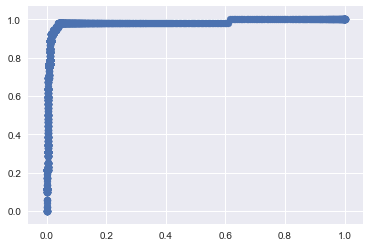

In [146]:
roc_x = []
roc_y = []
min_score = min(y_pred_roc)
max_score = max(y_pred_roc)
thr = np.linspace(min_score, max_score, 2000)
FP=0
TP=0

N = (y_test_s ==0).sum()
P = (y_test_s ==1).sum()

for (i, T) in enumerate(thr):
    for i in range(0, len(y_pred_roc)):
        if (y_pred_roc[i] > T):
            if (y_test_s.iloc[i]==1):
                TP = TP + 1
            if (y_test_s.iloc[i]==0):
                FP = FP + 1
    roc_x.append(FP/float(N))
    roc_y.append(TP/float(P))
    FP=0
    TP=0

plt.scatter(roc_x, roc_y)
plt.show()